<a href="https://colab.research.google.com/github/ksbs22/English-Project/blob/main/Rocks_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 112 kB 2.7 MB/s 
     |████████████████████████████████| 455 kB 17.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
voila 0.3.0 requires nbconvert<7,>=6.0.0, but you have nbconvert 5.6.1 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

  Using cached nbconvert-6.3.0-py3-none-any.whl (556 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.3.0 which is incompatible.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


# From Model to Production

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', '6cef4c7e60784ac38f3dfd1af0bcba67')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'metamorphic rock')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
#hide
#ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
dest = gdrive/'metamorphic.jpg'
download_url(ims[0], dest)

Path('/content/gdrive/My Drive/metamorphic.jpg')

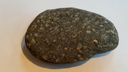

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
rock_types = 'igneous rock','metamorphic rock','sedimentary rock'
path = gdrive/'rocks'

In [11]:
if not path.exists():
    path.mkdir()
    for o in rock_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} rock')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#416) [Path('/content/gdrive/My Drive/rocks/igneous rock/00000005.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000001.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000003.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000008.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000004.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000009.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000011.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000000.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000007.jpg'),Path('/content/gdrive/My Drive/rocks/igneous rock/00000012.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#0) []

In [14]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [15]:
rocks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = rocks.dataloaders(path)

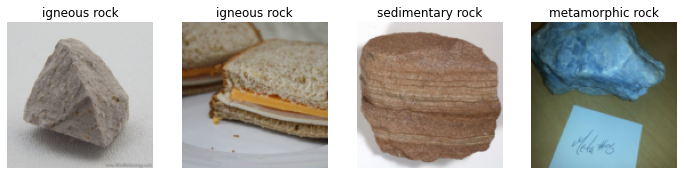

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

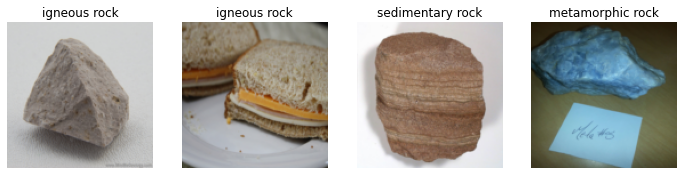

In [18]:
rocks = rocks.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = rocks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

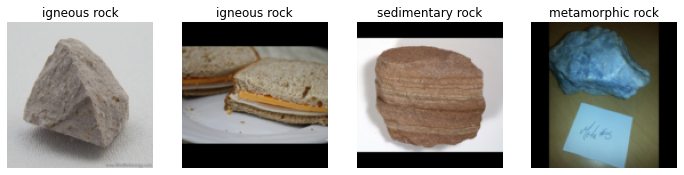

In [19]:
rocks = rocks.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = rocks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

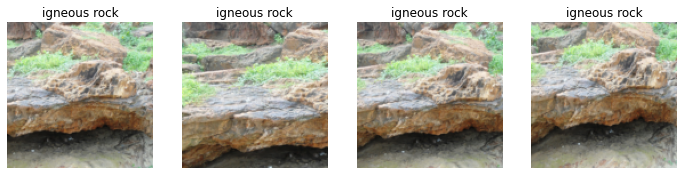

In [20]:
rocks = rocks.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = rocks.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


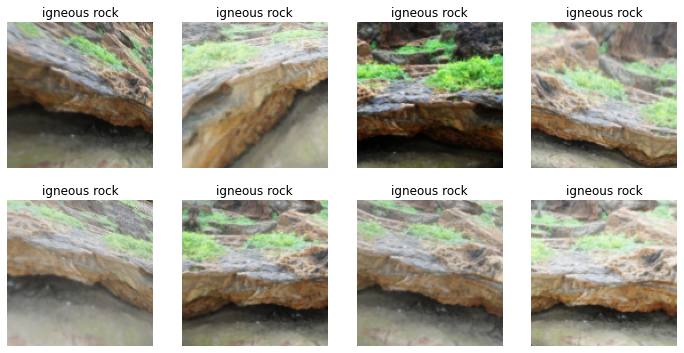

In [21]:
rocks = rocks.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = rocks.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [22]:
rocks = rocks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = rocks.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.784499,1.306534,0.518072,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.476901,1.142894,0.469880,00:17
1,1.415019,1.022787,0.421687,00:17
2,1.297895,0.971637,0.433735,00:17
3,1.243282,0.960959,0.421687,00:18


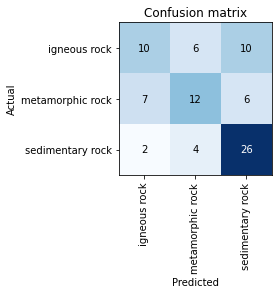

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

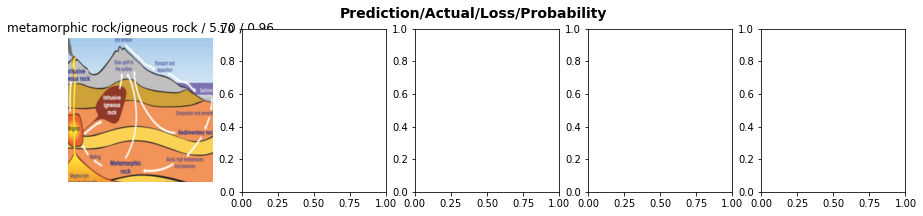

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [28]:
learn.export(gdrive/'rock_export.pkl')

In [29]:
path = gdrive
path.ls(file_exts='.pkl')

(#1) [Path('/content/gdrive/My Drive/rock_export.pkl')]

In [30]:
learn_inf = load_learner(path/'rock_export.pkl')

In [31]:
learn_inf.predict(gdrive/'metamorphic.jpg')

('metamorphic rock', TensorBase(1), TensorBase([0.4872, 0.4915, 0.0213]))

In [32]:
learn_inf.dls.vocab

['igneous rock', 'metamorphic rock', 'sedimentary rock']

### Creating a Notebook App from the Model

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
#hide
# For the book, we can't actually click an upload button, so we fake it
#btn_upload = SimpleNamespace(data = ['images/metamorphic.jpg'])

In [37]:
img = PILImage.create(btn_upload.data[-1])

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: igneous rock; Probability: 0.5300')

In [42]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Select your rock!'), 
      btn_upload, btn_run, out_pl, lbl_pred])